In [ ]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()
print(len(train_images))  
train_images

11501568/11490434 [==============================] - 0s 0us/step
60000


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
buffer_size = 60000
batch_size = 256
 
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
train_dataset

<BatchDataset shapes: (None, 28, 28), types: tf.uint8>

In [ ]:
# Creating the generator model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2DTranspose, LeakyReLU, Reshape

def generator():
  generator = tf.keras.Sequential()
  generator.add(Dense(7*7*256, use_bias = False, input_shape = (100,)))  # Random size of input, then after iterations, a sensible output is generated
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())  # Leaky relu is advanced activation, hence it is present as a layer, not as attribute, we add all advanced activations like this

  generator.add(Reshape((7,7,256)))
  assert generator.output_shape == (None, 7, 7, 256)

  generator.add(Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same', use_bias = False))
  assert generator.output_shape == (None, 7, 7, 128)
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())

  generator.add(Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same', use_bias = False))
  assert generator.output_shape == (None, 14, 14, 64)
  generator.add(BatchNormalization())
  generator.add(LeakyReLU())

  generator.add(Conv2DTranspose(1, (5,5), strides = (2,2), padding = 'same', use_bias = False))
  assert generator.output_shape == (None, 28, 28, 1)

  return generator

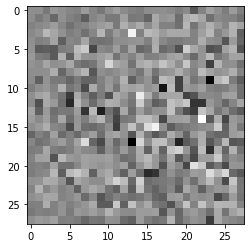

In [ ]:
noise = tf.random.normal([1,100])
generated_image = generator()(noise, training = False)
plt.imshow(generated_image[0, : , : , 0], cmap = 'gray')

In [ ]:
# The discriminator is a CNN-based image classifier

from tensorflow.keras.layers import Dense, Conv2D, LeakyReLU, Dropout, Flatten

def discriminator():

  discriminator = tf.keras.Sequential()
  discriminator.add(Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = [28, 28, 1]))
  discriminator.add(LeakyReLU())
  discriminator.add(Dropout(0.3))

  discriminator.add(Conv2D(128, (5,5), strides = (2,2), padding = 'same'))
  discriminator.add(LeakyReLU())
  discriminator.add(Dropout(0.3))

  discriminator.add(Flatten())
  discriminator.add(Dense(1))

  return discriminator

In [ ]:
decision = discriminator()(generated_image)
print(decision)

tf.Tensor([[-0.00125847]], shape=(1, 1), dtype=float32)


In [ ]:
# Define loss functions and optimizers for both models

from tensorflow.keras.losses import BinaryCrossentropy

cross_entropy = BinaryCrossentropy(from_logits = True)

In [ ]:
# Discriminator loss: This method quantifies how well the discriminator is able to distinguish real images from fakes. 
# It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
# Generator loss : The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, 
# the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
  generator_loss = cross_entropy(fake_output, tf.ones_like(fake_output))
  return generator_loss

In [ ]:
# The discriminator and the generator optimizers are different since you will train two networks separately.

from tensorflow.keras.optimizers import Adam

generator_optimizer = Adam(0.0001)
discriminator_optimizer = Adam(0.0001)

In [ ]:
# Define the training loop

# The training loop begins with generator receiving a random seed(i call it generate_random_image) as input. That seed is used to produce an image. 
# The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).
# The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.


num_examples = 16
noise_dim = 100

generated_random_image = tf.random.normal([num_examples, noise_dim])

print(generated_random_image)  # plot the image

tf.Tensor(
[[-1.1875551  -0.0972053  -1.211202   ...  0.39996424 -1.3678049
  -0.11390045]
 [-0.8317131  -0.5789914   0.88771564 ...  0.6092219   0.00495967
   0.35519394]
 [ 0.274243    0.09649315  0.49337253 ...  0.25434428  0.7999034
   0.7522876 ]
 ...
 [-0.69408435  0.3339197  -1.0440907  ... -0.69192547 -1.3523923
  -0.15083574]
 [-1.6717461   0.7881858   1.8160177  ...  1.1185095   1.0586905
   1.4270766 ]
 [ 0.3555735   0.54638565  1.485816   ... -1.673682    0.89417595
  -0.12411515]], shape=(16, 100), dtype=float32)


In [ ]:
# Produce images for the GIF as you go

def generate_and_save_images(model, epoch, test_input):

  # Notice below training is set to False , this is so that all layers run in inference mode(batchnorm)

  predictions = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
generator = generator()
discriminator = discriminator()

In [ ]:
epochs = 25  # Run for 50 epoch in article, first try 20
noise_dim = 100

def train(dataset, epochs):
  for epoch in range(epochs):
    print(epoch)
    for image_batch in train_dataset:
      noise = tf.random.normal([batch_size, noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(noise, training = True)

        real_output = discriminator(image_batch, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs, generated_random_image)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

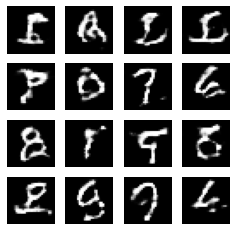

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

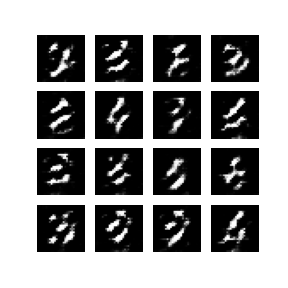

In [ ]:
display_image(5)

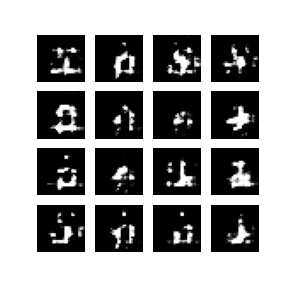

In [ ]:
display_image(10)

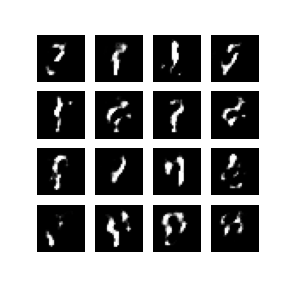

In [ ]:
display_image(15)

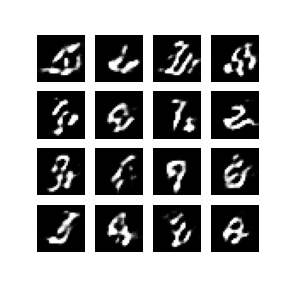

In [ ]:
display_image(20)

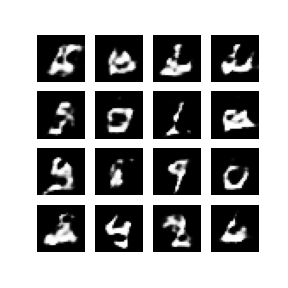

In [ ]:
display_image(25)

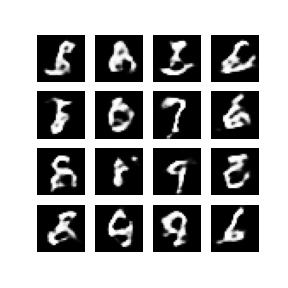

In [ ]:
display_image(30)

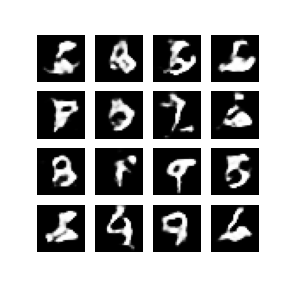

In [ ]:
display_image(35)

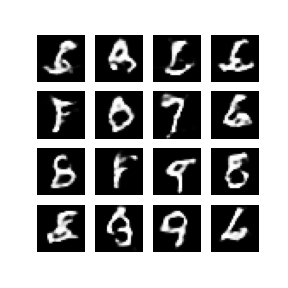

In [ ]:
display_image(40)

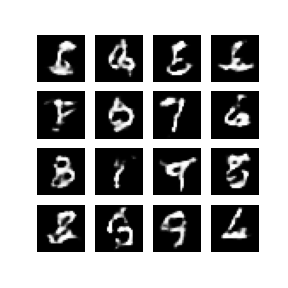

In [ ]:
display_image(45)

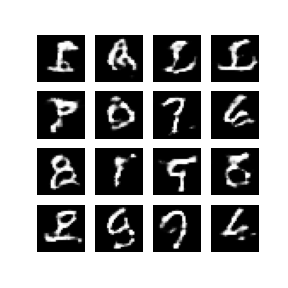

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


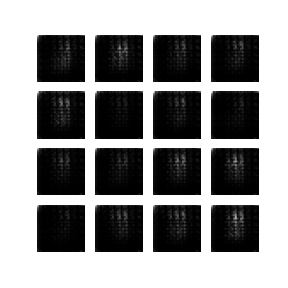

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)